***
# Easy Cash - Credit Risk Classification
Uma das área que causa mais problemas para bancos, financiadoras e empresários é a taxa de inadimplência por parte da sua carteira de clientes. Avaliar se uma pessoa irá deixar de cumprir com suas obrigações financeiras é de extrema importância, e pode causar um grande impacto no balanço da Instituição. Cada vez mais soluções vêm sendo desenvolvidas e aprimoradas visando minimizar o ***risco de default***.


***Defaulf:*** é o termo utilizado para indicar o não cumprimento das obrigações e/ou condições de um empréstimo (como financiamentos ou dívidas de cartão de crédito)
***

## 1. BUSINESS UNDERSTANDING

#### Business Problem
A Easy Cash é um banco digital que atua desde 2015 no Brasil oferecendo produtos financeiros como: cartões de crédito, seguros e emprestímos. Uma das área que causa mais problemas para bancos, fintechs é a taxa de inadimplência por parte da sua carteira de clientes. No último resultado trimestral divulgado pela empresa, a diretoria financeira, comunicou que o número de inadimplentes após a liberação de crédito aumentou significativamente, tendo o ***EL (Expected Loss)*** com um aumento de 15% representando um ***EC (Economic Capital)*** de R$ 6.2 milhões para cobrir essas perdas inesperadas. 
Portanto, foi solicitado ao time de Data Science, que realizasse um estudo das informações financeiras e das solicitações de empréstimo para encontrar padrões que possam indicar uma possível inadimplência e determinar quais ações possam ser implementadas, afim de, reduzir estas perdas financeiras por conta de pessoas mutuárias que não quitam suas dívidas.

Além do objetivo á ser alcançado o diretor solicitou um relatório respondendo algumas questões para ser validadas:
- Hypothesis #1: Clientes mais jovens (abaixo de 30 anos de idade) são responsáveis pelo número elevado de inadimplência?
- Hypothesis #2: 

## 2. DATA UNDERSTANDING

### 2.0 IMPORTING LIBRARIES

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.rc('figure', figsize = (12,6))

### 2.1 LOADING DATA

A base de dados foi disponibilizada pelo cliente em 4 tabelas distintas (descritas abaixo) no formato de dumps (.sql), os dados das tabelas foram carregados no banco de dados ` analise_risco` no MySQL, posteriormente foi realizado o ***union data*** consolidando os dados em apenas uma tabela `dados_juntos.csv` exportado em formato .csv para consumo.

Para consultar o dicionário de dados , consulte o readme: `/data/readme.md`

In [2]:
dados = pd.read_csv('../data/raw/dados_unidos.csv')
dados.head(10)

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,21.0,60000.0,Rent,2.0,Education,B,8000.0,11.26,0.0,0.13,N,3.0
1,40.0,70000.0,Mortgage,6.0,Education,A,18000.0,7.90,0.0,0.26,N,14.0
2,29.0,115000.0,Mortgage,3.0,Medical,C,22000.0,15.23,0.0,0.19,Y,7.0
3,26.0,84996.0,Rent,0.0,Medical,B,9000.0,11.26,0.0,0.11,N,2.0
4,23.0,54500.0,Rent,2.0,Debtconsolidation,A,8000.0,NaN,0.0,0.15,N,2.0
5,40.0,44000.0,Rent,0.0,Personal,A,6000.0,NaN,1.0,0.14,N,12.0
6,23.0,24000.0,Own,7.0,Education,A,5000.0,7.49,0.0,0.21,N,2.0
7,27.0,56253.0,Rent,11.0,Venture,B,10000.0,11.36,0.0,0.18,N,8.0
8,32.0,19200.0,Rent,0.0,Venture,B,5000.0,9.99,1.0,0.26,N,6.0
9,24.0,18000.0,Own,0.0,Homeimprovement,A,6250.0,6.54,1.0,0.35,N,4.0


In [3]:
# Verificando a qtd de registros
print(f'Número de Registros: {dados.shape[0]}')
print(f'Número de Colunas: {dados.shape[1]}')

Número de Registros: 34501
Número de Colunas: 12


### 2.2 RENAMING COLUMNS E DATA

In [4]:
# Renomeando nomes das colunas - tradução (en -> pt)
dict_col_name = {
    'person_age': 'idade_usuario',
    'person_income': 'salario_usuario',
    'person_home_ownership': 'situacao_moradia_usuario',
    'person_emp_length': 'tempo_de_trabalho_usuario',
    'loan_intent': 'motivo_emprestimo',
    'loan_grade': 'pontuacao_emprestimo',
    'loan_amnt': 'valor_emprestimo',
    'loan_int_rate': 'taxa_juros_emprestimo',
    'loan_status': 'status_emprestimo',
    'loan_percent_income': 'renda_percentual_emprestimo',
    'cb_person_default_on_file': 'devendo',
    'cb_person_cred_hist_length': 'tempo_de_credito'
}
# axis=1 -> coluna
dados.rename(dict_col_name, axis= 1, inplace=True)

In [5]:
# Renomeando dados das linhas - tradução (en -> pt)
dict_situacao_moradia = {
    'Rent': 'Alugada',
    'Own': 'Propria',
    'Mortgage': 'Hipotecada',
    'Other': 'Outros'
}

dict_motivo_emprestimo = {
    'Personal':'Pessoal',
    'Education': 'Educativo',
    'Medical':'Medico',
    'Venture':'Empreendimento',
    'Homeimprovement': 'Melhoria do Lar',
    'Debtconsolidation': 'Pagamento de Debitos'
}
# axis=0 (default) -> linhas
dados.replace(dict_situacao_moradia, inplace=True)
dados.replace(dict_motivo_emprestimo, inplace=True)

### 2.3 CLEANING DATA


Sabemos que boa parte do tempo e sucesso de um projeto de Machine Learning concentrasse na limpeza dos dados, os dados preparados permitem que os modelos treinem mais rapidamente, além de impactar significativamente o desempenho do modelo, desta forma será garantido a qualidade da base de dados, tratando valores ausentes, nulos e remoção de outliers.

### i) Missing Data

In [6]:
# Verificando a presença de valores nulos
dados.isnull().sum()

idade_usuario                   324
salario_usuario                 339
situacao_moradia_usuario        331
tempo_de_trabalho_usuario      1254
motivo_emprestimo               315
pontuacao_emprestimo            313
valor_emprestimo                331
taxa_juros_emprestimo          3630
status_emprestimo               343
renda_percentual_emprestimo     319
devendo                         370
tempo_de_credito                  4
dtype: int64

**NOTAS:** É possível verificar que há dados nulos/ausentes em todas as categorias sejam de dados númericos ou categóricos, que precisam ser tratados. 

##### DROPNA( ) - Removendo dados ausentes
a) `status_emprestimo`: Os dados ausentes na nossa variável default `status_emprestimo` não poderá ser utilizado para prever a probabilidade de inadimplência, porque não saberemos se o empréstimo foi inadimplente ou não, além de se tratar da resposta que procuramos da variável dependente.

b) `taxa_juros_emprestimo`: De forma semelhante ao item anterior, ter dados ausentes neste campo dificultará as previsões do modelo. Como as taxas de juros são definidas pela empresa, e temos valores ausentes nela, é provável que tenha ocorrido alguns erros durante a ingestão de dados.

Portanto, afim de garantir a qualidade dos dados, o time entendeu que seria melhor remover a presença de dados nulos nestes dataset e decidir não fazer qualquer tipo de preenchimento para que não seja adicionado nenhum ruído nos dados.

In [7]:
# Deletando valores ausentes
dados_tratados = dados.dropna()
dados_tratados.isnull().sum()

idade_usuario                  0
salario_usuario                0
situacao_moradia_usuario       0
tempo_de_trabalho_usuario      0
motivo_emprestimo              0
pontuacao_emprestimo           0
valor_emprestimo               0
taxa_juros_emprestimo          0
status_emprestimo              0
renda_percentual_emprestimo    0
devendo                        0
tempo_de_credito               0
dtype: int64

### ii) Outilers

In [8]:
# Verificando os dados numéricos
dados_tratados.describe()

,idade_usuario,salario_usuario,tempo_de_trabalho_usuario,valor_emprestimo,taxa_juros_emprestimo,status_emprestimo,renda_percentual_emprestimo,tempo_de_credito
count,28638.000000,2.863800e+04,28638.000000,28638.000000,28638.000000,28638.000000,28638.000000,28638.000000
mean,27.727216,6.664937e+04,4.788672,9656.493121,11.039867,0.216600,0.169488,5.793736
std,6.310441,6.235645e+04,4.154627,6329.683361,3.229372,0.411935,0.106393,4.038483
min,20.000000,4.000000e+03,0.000000,500.000000,5.420000,0.000000,0.000000,2.000000
25%,23.000000,3.948000e+04,2.000000,5000.000000,7.900000,0.000000,0.090000,3.000000
50%,26.000000,5.595600e+04,4.000000,8000.000000,10.990000,0.000000,0.150000,4.000000
75%,30.000000,8.000000e+04,7.000000,12500.000000,13.480000,0.000000,0.230000,8.000000
max,144.000000,6.000000e+06,123.000000,35000.000000,23.220000,1.000000,0.830000,30.000000


>É possivel identificar através dos valores `máx` a presença de outliers nos dados de `idade_usuario` e `salario_usuario` e `tempo_de_trabalho_usuario`.  Vamos verificar através de um boxplot para entender melhor o comportamento destes dados.

<AxesSubplot:>

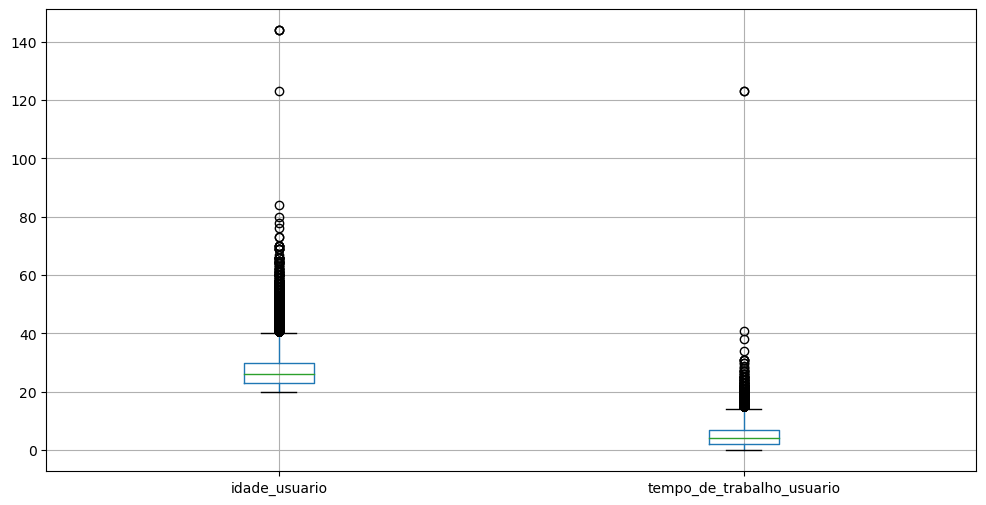

In [9]:
# BOXPLOT: Visualizando os dados de idade e tempo de trabalho
dados_tratados.boxplot(['idade_usuario', 'tempo_de_trabalho_usuario'])

In [10]:
# SUBSETING: Removendo dados com idade superior á 100 anos
dados_tratados = dados_tratados[(dados_tratados['idade_usuario'] < 100)]

In [11]:
# SUBSETING: Removendo dados com tempo de trabalho superior á 60 anos
dados_tratados = dados_tratados[dados_tratados['tempo_de_trabalho_usuario'] < 60 ]

<AxesSubplot:>

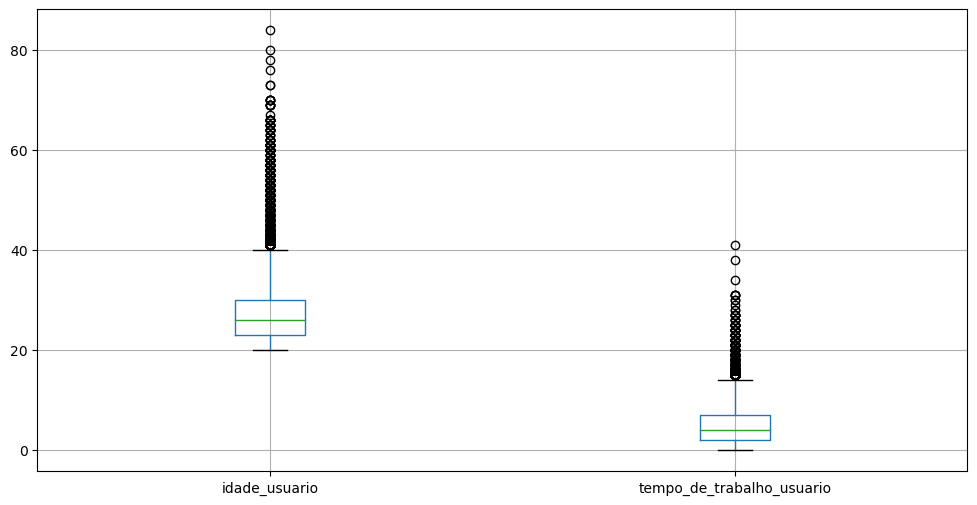

In [12]:
# BOXPLOT: Visualizando os dados após remoção
dados_tratados.boxplot(['idade_usuario', 'tempo_de_trabalho_usuario'])

<AxesSubplot:>

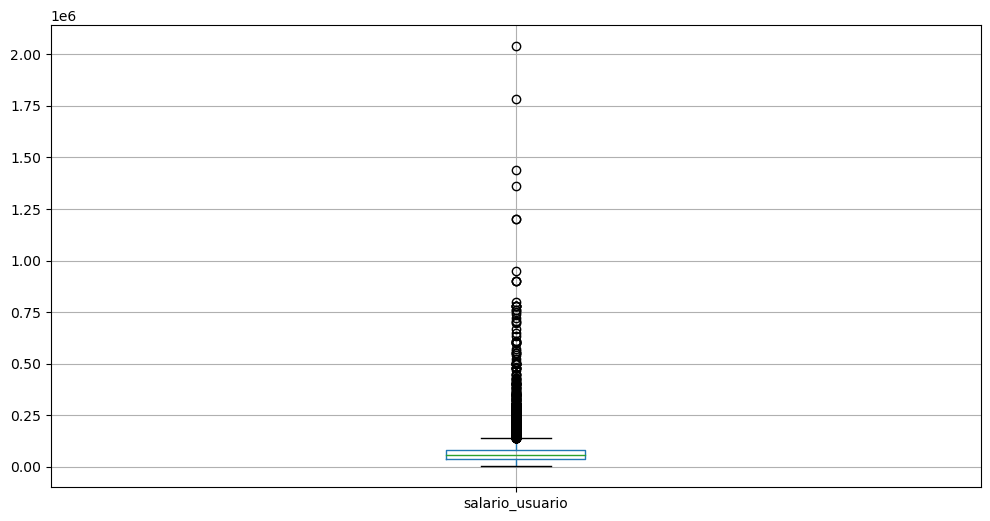

In [13]:
# BOXPLOT: Visualizando os dados de salário
dados_tratados.boxplot(['salario_usuario'])

In [14]:
# SUBSETING ROWS: Vamos listar estes salários acima de 1Mi para verificamos mais detalhes
dados_tratados[dados_tratados['salario_usuario'] > 1000000 ].head()

,idade_usuario,salario_usuario,situacao_moradia_usuario,tempo_de_trabalho_usuario,motivo_emprestimo,pontuacao_emprestimo,valor_emprestimo,taxa_juros_emprestimo,status_emprestimo,renda_percentual_emprestimo,devendo,tempo_de_credito
14717,32.0,1200000.0,Hipotecada,1.0,Empreendimento,A,12000.0,7.51,0.0,0.01,N,8.0
27729,42.0,2039784.0,Alugada,0.0,Empreendimento,C,8450.0,12.29,0.0,0.00,Y,15.0
32532,47.0,1362000.0,Hipotecada,9.0,Empreendimento,A,6600.0,7.74,0.0,0.00,N,17.0
32945,36.0,1200000.0,Propria,16.0,Medico,A,10000.0,6.54,0.0,0.01,N,11.0
34348,44.0,1440000.0,Hipotecada,7.0,Pagamento de Debitos,A,6400.0,7.40,0.0,0.00,N,15.0


NOTA: Obtivemos 4 registros de clientes que ganham acima de 1 milhão e verificando o valor de emprestimo solicitado, vemos valores entre muito baixo entre 6.6K á 12K para uma pessoa que ganha acima de 1 Mi USD, sendo assim, o time resolveu remover estes dados. 

In [16]:
# SUBSETING: Removendo dados com salários acima de 1 milhão
dados_tratados = dados_tratados[dados_tratados['salario_usuario'] < 1000000]

<AxesSubplot:>

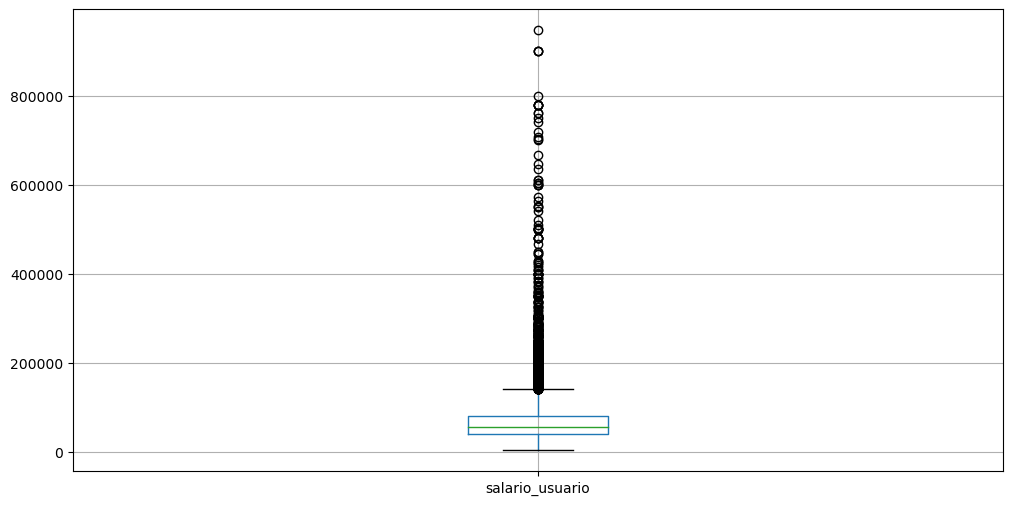

In [17]:
# BOXPLOT: Visualizando os dados de salário após remoção
dados_tratados.boxplot(['salario_usuario'])

### iii) Categorical Data Inconsistency

##### Verificando inconsistência nos dados categóricos

In [18]:
dados_tratados['situacao_moradia_usuario'].unique()

array(['Alugada', 'Hipotecada', 'Propria', 'Outros'], dtype=object)

In [19]:
dados_tratados['situacao_moradia_usuario'].unique()

array(['Alugada', 'Hipotecada', 'Propria', 'Outros'], dtype=object)

In [20]:
dados_tratados['motivo_emprestimo'].unique()

array(['Educativo', 'Medico', 'Empreendimento', 'Melhoria do Lar',
       'Pessoal', 'Pagamento de Debitos'], dtype=object)

In [21]:
dados_tratados['pontuacao_emprestimo'].unique()

array(['B', 'A', 'C', 'D', 'F', 'E', 'G'], dtype=object)

In [22]:
dados_tratados['status_emprestimo'].unique()

array([0., 1.])

In [23]:
dados_tratados['devendo'].unique()

array(['N', 'Y'], dtype=object)

### 2.4 DATA TYPES




In [24]:
# Verificando o tipo de dados
dados_tratados.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28626 entries, 0 to 34500
Data columns (total 12 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   idade_usuario                28626 non-null  float64
 1   salario_usuario              28626 non-null  float64
 2   situacao_moradia_usuario     28626 non-null  object 
 3   tempo_de_trabalho_usuario    28626 non-null  float64
 4   motivo_emprestimo            28626 non-null  object 
 5   pontuacao_emprestimo         28626 non-null  object 
 6   valor_emprestimo             28626 non-null  float64
 7   taxa_juros_emprestimo        28626 non-null  float64
 8   status_emprestimo            28626 non-null  float64
 9   renda_percentual_emprestimo  28626 non-null  float64
 10  devendo                      28626 non-null  object 
 11  tempo_de_credito             28626 non-null  float64
dtypes: float64(8), object(4)
memory usage: 2.8+ MB


Vamos alterar o tipo de dados conforme o dicionário de dados e em seguida resetar o index para ficar ordenado após a remoção dos dados

### i) Dtype

In [25]:
# Alteração do Dtype do tipo float64 para int64
dados_tratados['idade_usuario'] = dados_tratados['idade_usuario'].astype('int64')
dados_tratados['tempo_de_trabalho_usuario'] = dados_tratados['tempo_de_trabalho_usuario'].astype('int64')
dados_tratados['status_emprestimo'] = dados_tratados['status_emprestimo'].astype('int64')
dados_tratados['tempo_de_credito'] = dados_tratados['tempo_de_credito'].astype('int64')

C:\Users\reyna\AppData\Local\Temp\ipykernel_6796\788446026.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dados_tratados['idade_usuario'] = dados_tratados['idade_usuario'].astype('int64')
C:\Users\reyna\AppData\Local\Temp\ipykernel_6796\788446026.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dados_tratados['tempo_de_trabalho_usuario'] = dados_tratados['tempo_de_trabalho_usuario'].astype('int64')
C:\Users\reyna\AppData\Local\Temp\ipykernel_6796\788446026.py:4: SettingWithCopyWarning: 
A value is t

### ii)  Reset Index

In [26]:
dados_tratados.index = range(dados_tratados.shape[0])
dados_tratados.index

RangeIndex(start=0, stop=28626, step=1)

In [27]:
# Imprimindo na tela informações do dataframe
n_linha_removidas =  dados.shape[0] - dados_tratados.shape[0]
p_linha_removidas = ((n_linha_removidas / dados.shape[0]) * 100)

print(f'Número de Registros Atual: {dados_tratados.shape[0]}')
print(f'Total de Registros removidos: {n_linha_removidas} / Percentual: {p_linha_removidas} %')

Número de Registros Atual: 28626
Total de Registros removidos: 5875 / Percentual: 17.028491927770208 %


### 2.5 EXPLORING DATA


In [28]:
# Visualizando os dados
dados_tratados.head()

,idade_usuario,salario_usuario,situacao_moradia_usuario,tempo_de_trabalho_usuario,motivo_emprestimo,pontuacao_emprestimo,valor_emprestimo,taxa_juros_emprestimo,status_emprestimo,renda_percentual_emprestimo,devendo,tempo_de_credito
0,21,60000.0,Alugada,2,Educativo,B,8000.0,11.26,0,0.13,N,3
1,40,70000.0,Hipotecada,6,Educativo,A,18000.0,7.90,0,0.26,N,14
2,29,115000.0,Hipotecada,3,Medico,C,22000.0,15.23,0,0.19,Y,7
3,26,84996.0,Alugada,0,Medico,B,9000.0,11.26,0,0.11,N,2
4,23,24000.0,Propria,7,Educativo,A,5000.0,7.49,0,0.21,N,2


In [29]:
# Verificando a taxa de inadimplentes
inadimplentes_perc = dados_tratados['devendo'].value_counts(normalize= True)
print(f'A Taxa de Pessoas com histórico de inadimplência é de {(inadimplentes_perc[1] * 100).round(2)}%')

A Taxa de Pessoas com histórico de inadimplência é de 17.82%


In [40]:
dados_tratados.corr()

,idade_usuario,salario_usuario,tempo_de_trabalho_usuario,valor_emprestimo,taxa_juros_emprestimo,status_emprestimo,renda_percentual_emprestimo,tempo_de_credito
idade_usuario,1.000000,0.137346,0.175694,0.056147,0.010458,-0.022229,-0.038668,0.877345
salario_usuario,0.137346,1.000000,0.172787,0.357035,-0.001748,-0.180029,-0.316936,0.117377
tempo_de_trabalho_usuario,0.175694,0.172787,1.000000,0.108421,-0.058183,-0.086433,-0.059905,0.151175
valor_emprestimo,0.056147,0.357035,0.108421,1.000000,0.145882,0.113360,0.577326,0.045640
taxa_juros_emprestimo,0.010458,-0.001748,-0.058183,0.145882,1.000000,0.339297,0.123271,0.015379
status_emprestimo,-0.022229,-0.180029,-0.086433,0.113360,0.339297,1.000000,0.379469,-0.015312
renda_percentual_emprestimo,-0.038668,-0.316936,-0.059905,0.577326,0.123271,0.379469,1.000000,-0.029031
tempo_de_credito,0.877345,0.117377,0.151175,0.045640,0.015379,-0.015312,-0.029031,1.000000


<AxesSubplot:xlabel='salario_usuario', ylabel='status_emprestimo'>

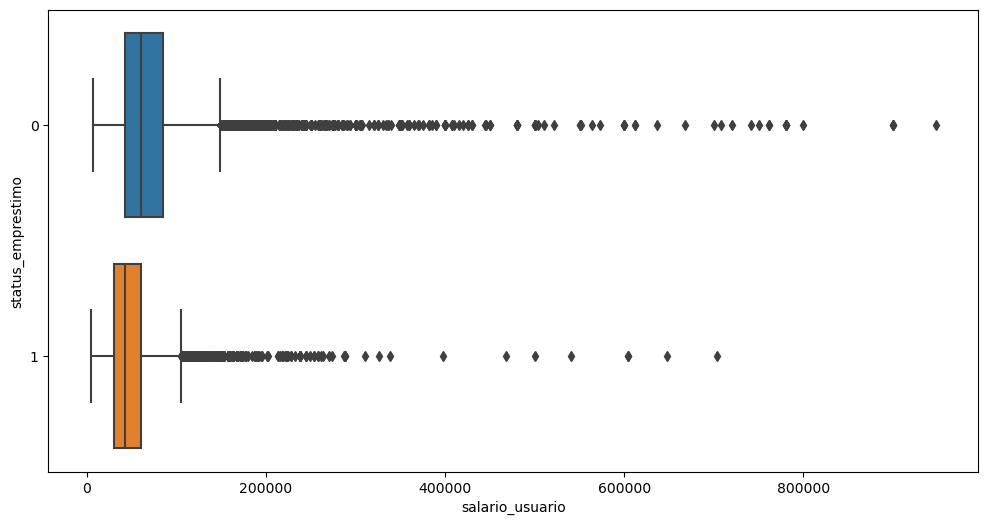

In [41]:
sns.boxplot(data = dados_tratados, y = 'status_emprestimo', x= 'salario_usuario', orient= 'h'  )

### Verificando a distribuição do valor de emprestimo

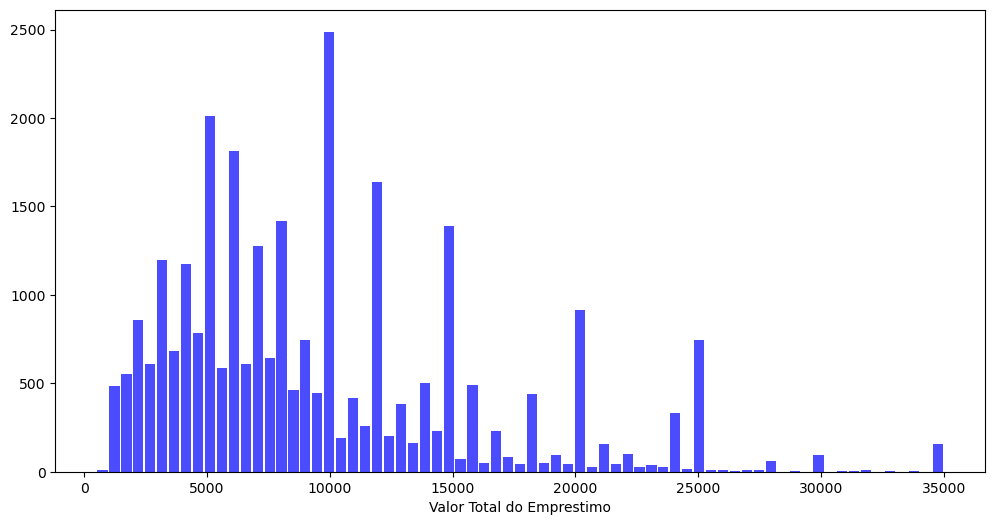

In [35]:
# Olhando a distribuição do valor de emprestimo com um histograma
n, bins, patches = plt.hist(x=dados_tratados['valor_emprestimo'], bins='auto', color='blue',alpha=0.7, rwidth=0.85)
plt.xlabel("Valor Total do Emprestimo")
plt.show()

### Plotando um Scatter Plot 
Verificando a relação entre a variável independente (`idade_usuario`) e a variável dependente (`salario_usuario`).

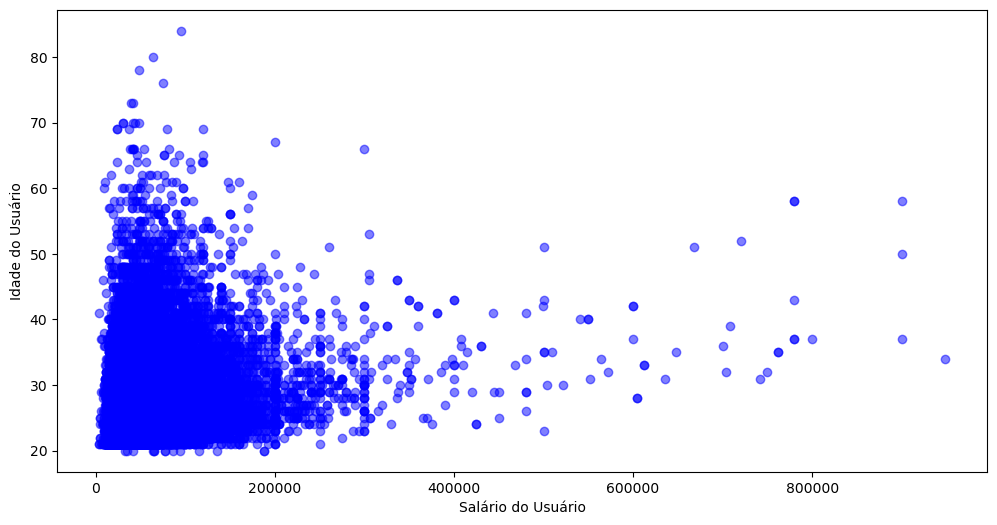

In [36]:
# Plotando um gráfico de dispersão entre a idade e o salário do usuário
plt.scatter(x = dados_tratados['salario_usuario'], y = dados_tratados['idade_usuario'], c ='blue', alpha = 0.5)
plt.xlabel('Salário do Usuário')
plt.ylabel('Idade do Usuário')
plt.show()

Já podemos ver uma correlação positiva com idade e renda, o que pode significar que essas pessoas mais velhos estão mais avançados em suas carreiras e, portanto, ganham salários mais altos. Também é possível identificar a presença de ***outiliers.***

### Análise Exploratória com Tabela Cruzada

Dados Financeiros geralmente são visualizados em formato de tabelas parecidos com planilhas em excel, sendo assim, vamos usar o método  pd.crosstab() para visualizar melhor.

Para a maioria dos modelos de risco de crédito, especialmente para probabilidade de inadimplência, colunas como `tempo_de_trabalho_usuario` e `moradia_usuario` são comuns para começar a investigar.

Você poderá ver como os valores são preenchidos nos dados e visualizá-los. Por enquanto, você precisa verificar como o "status_do_emprestimo" é afetado por fatores como o status da moradiaa, o grau do empréstimo e a porcentagem da renda do empréstimo.

In [ ]:
pd.crosstab(index=dados['situacao_moradia_usuario'], columns= dados['status_emprestimo'],
            values=dados['taxa_juros_emprestimo'], aggfunc='mean').round(2)

In [ ]:
pd.crosstab(index= dados['motivo_emprestimo'], columns= dados['status_emprestimo'], margins = True)

In [ ]:
pd.crosstab(index= dados['situacao_moradia_usuario'], columns= dados['status_emprestimo'],
              values=dados['renda_percentual_emprestimo'], aggfunc='mean')

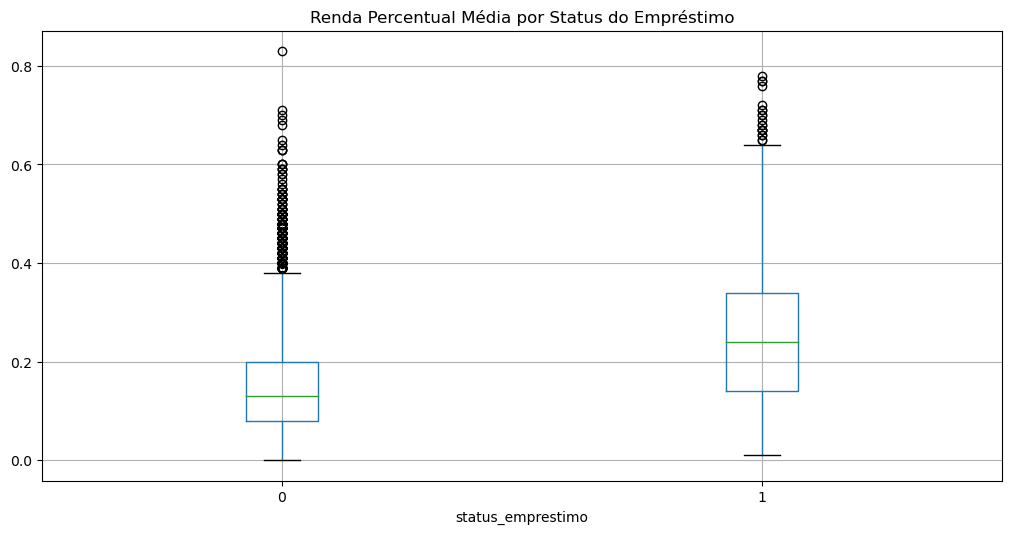

In [43]:
# Box Plot da Renda Percentual Média por Status do Empréstimo
dados_tratados.boxplot(column = ['renda_percentual_emprestimo'], by = 'status_emprestimo')
plt.title('Renda Percentual Média por Status do Empréstimo')
plt.suptitle('')
plt.show()

A porcentagem média de renda para inadimplentes (=1) é maior do que os adimplentes. Isso pode indicar que essas pessoas têm uma relação dívida/renda que já é muito alta.